# General Setup

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, quantities
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit

category =  "config2"



Automatic pdb calling has been turned OFF


In [2]:
############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

# Run

In [3]:
run = 21
theta = 0
qois = ['comp(u,0)', 'comp(u,2)']

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'
oak_probes_dir =  f'{home_dir}/CHARLES/{category}/R{run}/probes/probesOut_parquet/'

In [4]:
# probes = probePost.Probes(probes_dir, directory_parquet=oak_probes_dir, file_type = "csv")
# probes.to_parquet(overwrite=True)

probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, file_type = "parquet")

In [5]:
stack = [1, 10, 20, 30, 40, 50]

start = 40000
stop = -1
by = 1

## Spectra

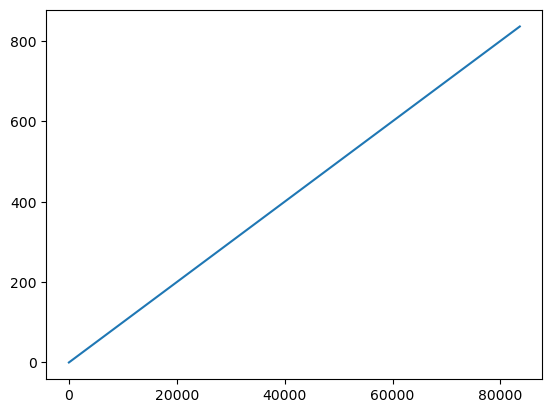

In [6]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)

processing data took 1 seconds
pressure data not founnd, replacing with zeros
processing data took 1 seconds
pressure data not founnd, replacing with zeros


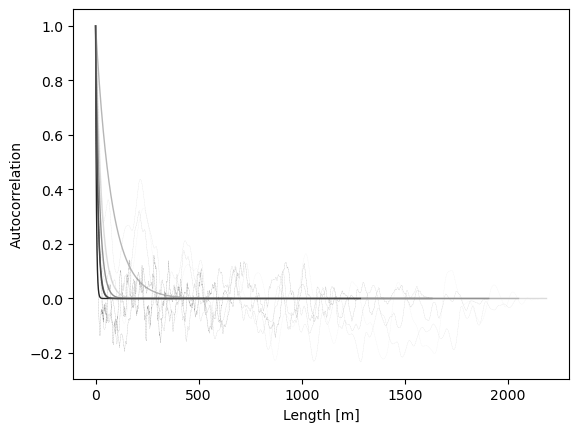

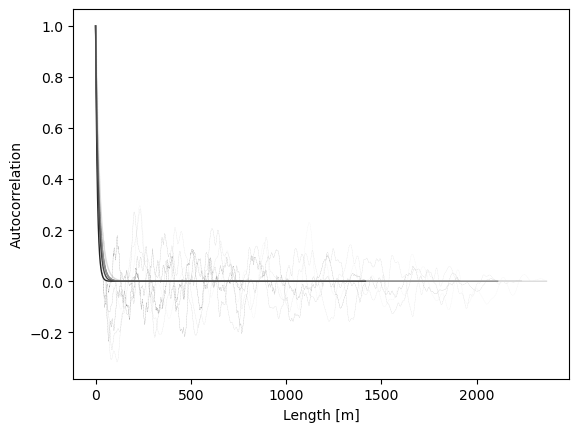

In [7]:
qty_dict = probes.create_qty_dict(
    theta_wind = theta,
    names = [name for name in  probes.probe_names if "Bx" in name],#[name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    stack = stack,
)


/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/pyCascade/quantities.py:299: RuntimeWarning: divide by zero encountered in power
  ax.loglog(qty.f, initial_offset*qty.f**(eval(scaling)), label = scaling)


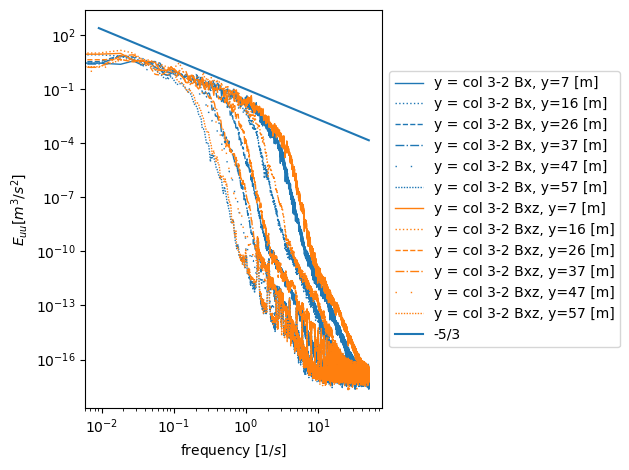

In [8]:
fig, ax = quantities.plot_power_spectra(qty_dict, var = 'Euu')

/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/pyCascade/quantities.py:299: RuntimeWarning: divide by zero encountered in reciprocal
  ax.loglog(qty.f, initial_offset*qty.f**(eval(scaling)), label = scaling)


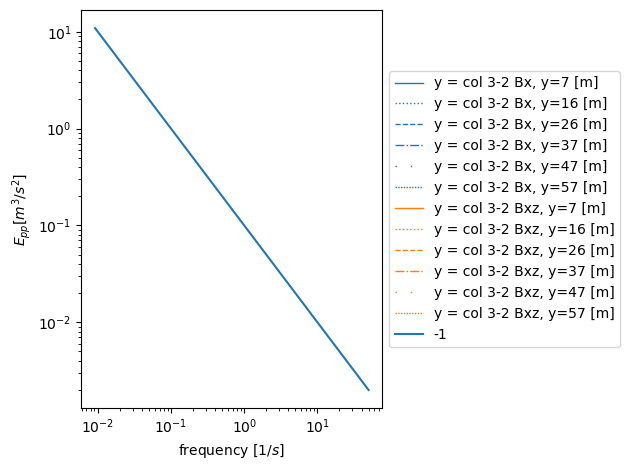

In [9]:
fig, ax = quantities.plot_power_spectra(qty_dict, var = "Epp", scaling = "-1")

## Plot ABL

processing data took 1 seconds
pressure data not founnd, replacing with zeros
processing data took 0 seconds
pressure data not founnd, replacing with zeros
processing data took 0 seconds
pressure data not founnd, replacing with zeros
processing data took 1 seconds
pressure data not founnd, replacing with zeros


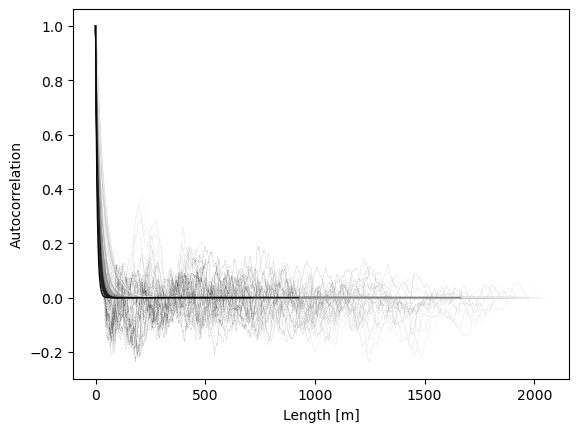

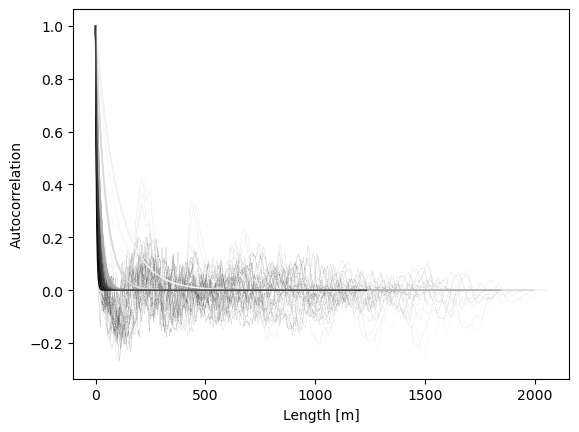

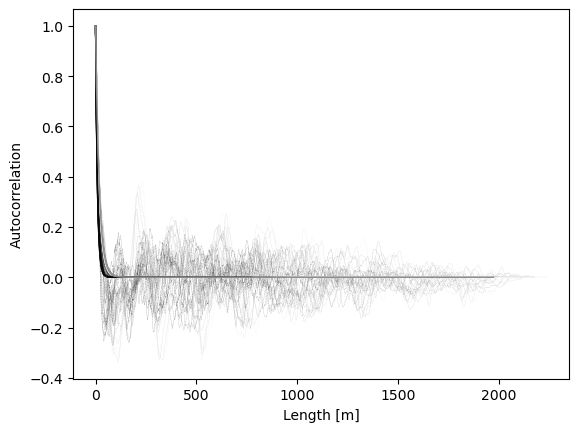

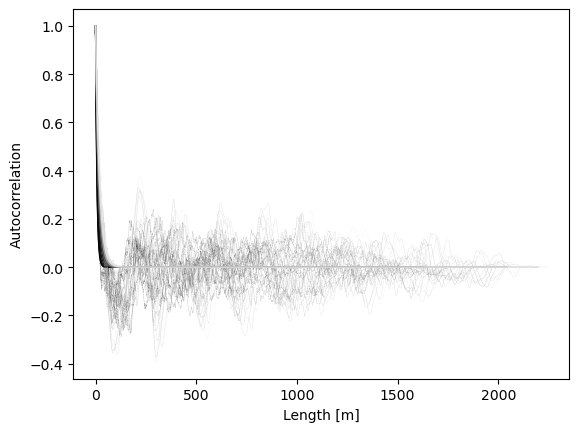

In [10]:
qty_dict = probes.create_qty_dict(
    theta_wind = theta,
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    stack = range(1,40)
)

col_3-2: u* = 0.7193601543138622, z0 = 3.109902102322152, disp = 0.0
col_3-2_Bx: u* = 0.7142867066306753, z0 = 3.0411779981793665, disp = 0.0
col_3-2_Bxz: u* = 0.6758457084774263, z0 = 1.840871417663273, disp = 2.2115347278282336
col_3-2_Bz: u* = 0.6431858864283915, z0 = 1.5598907138201803, disp = 2.5621783345291167


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='mean velocity [m/s]', ylabel='height [m]'>)

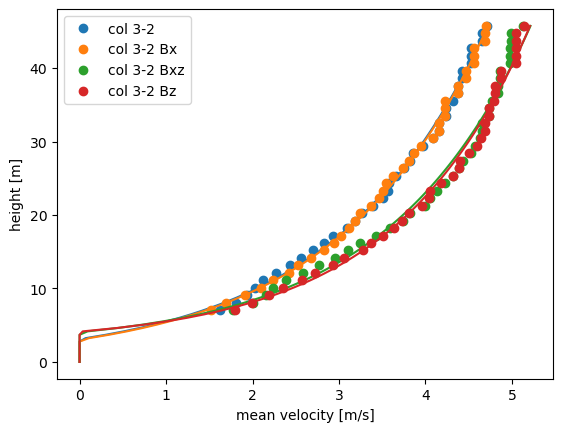

In [11]:
quantities.plot_ABL(qty_dict, fit_disp=True)

## Plot Length Scales

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': 'Lx'}, xlabel='y [m]', ylabel='L [m]'>,
        <Axes: title={'center': 'Ly'}, xlabel='y [m]'>,
        <Axes: title={'center': 'Lz'}, xlabel='y [m]'>], dtype=object))

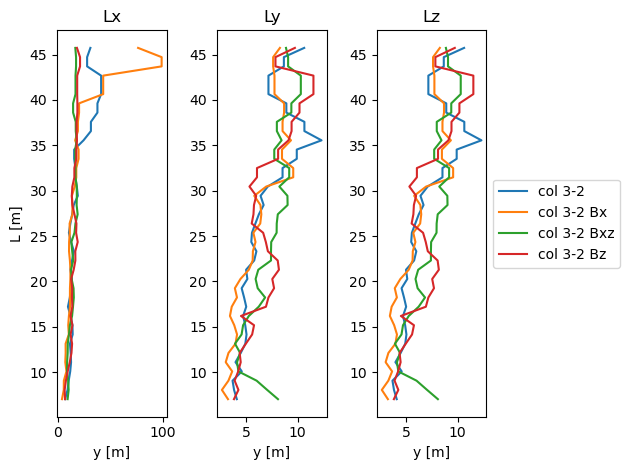

In [12]:
quantities.plot_length_scales(qty_dict)

## Plot Reynolds stresses

(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': 'uu'}, ylabel='y [m]'>,
         <Axes: title={'center': 'vv'}>, <Axes: title={'center': 'ww'}>],
        [<Axes: title={'center': 'uv'}, ylabel='y [m]'>,
         <Axes: title={'center': 'uw'}, xlabel='Reynolds Stress [m^2/s^2]'>,
         <Axes: title={'center': 'vw'}>]], dtype=object))

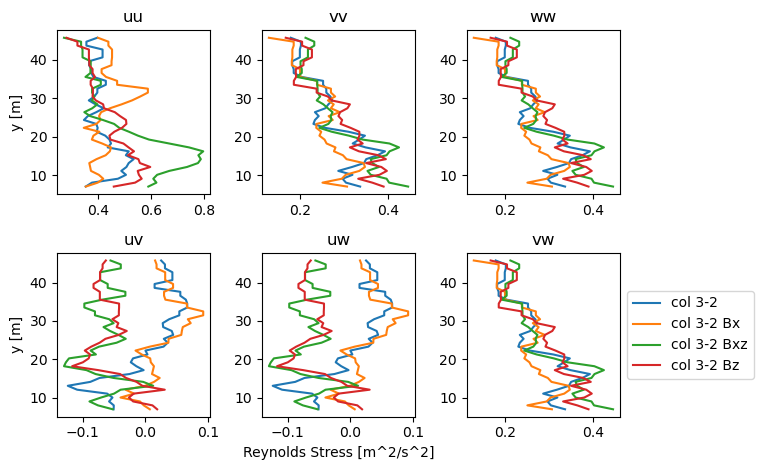

In [13]:
quantities.plot_reynolds_stresses(qty_dict)

## Plot Turbulence Intensities

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='Iu', ylabel='y [m]'>, <Axes: xlabel='Iv'>,
        <Axes: xlabel='Iw'>], dtype=object))

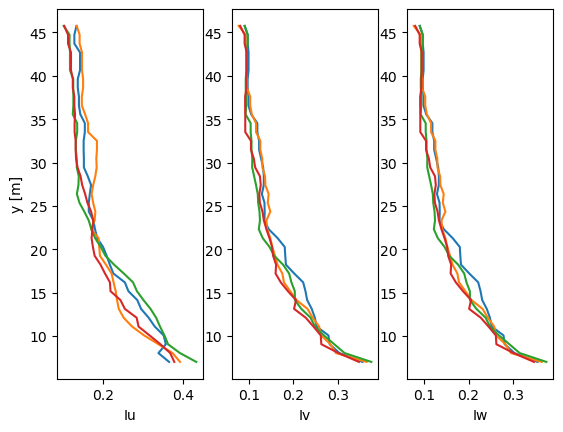

In [14]:
quantities.plot_turbulence_intensities(qty_dict)

## Plot prms

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Prms [Pa]', ylabel='y [m]'>)

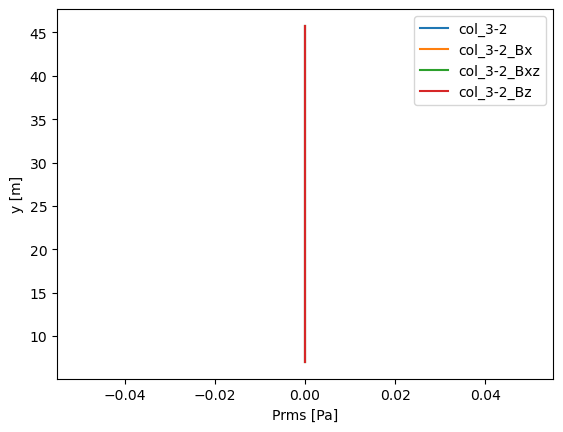

In [15]:
quantities.plot_prms(qty_dict)